In [2]:
import torch
import torchvision.transforms as transforms
import scipy.io as sio
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from ITrackerModel import ITrackerModel

In [3]:
FILENAME = 'checkpoint.pth.tar'
state = torch.load(FILENAME, map_location=torch.device('cpu'))

In [4]:
model = ITrackerModel()

model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [5]:
IMAGE_SIZE = (224, 224)
FACE_GRID_SIZE = (25, 25)

LEFT_EYE_MEAN_PATH = 'mean_left_224.mat'
RIGHT_EYE_MEAN_PATH = 'mean_right_224.mat'
FACE_MEAN_PATH = 'mean_face_224.mat'

left_eye_mean = sio.loadmat(LEFT_EYE_MEAN_PATH)['image_mean']
right_eye_mean = sio.loadmat(RIGHT_EYE_MEAN_PATH)['image_mean']
face_mean = sio.loadmat(FACE_MEAN_PATH)['image_mean']

left_eye_mean = np.array(left_eye_mean, dtype=float)
right_eye_mean = np.array(right_eye_mean, dtype=float)
face_mean = np.array(face_mean, dtype=float)

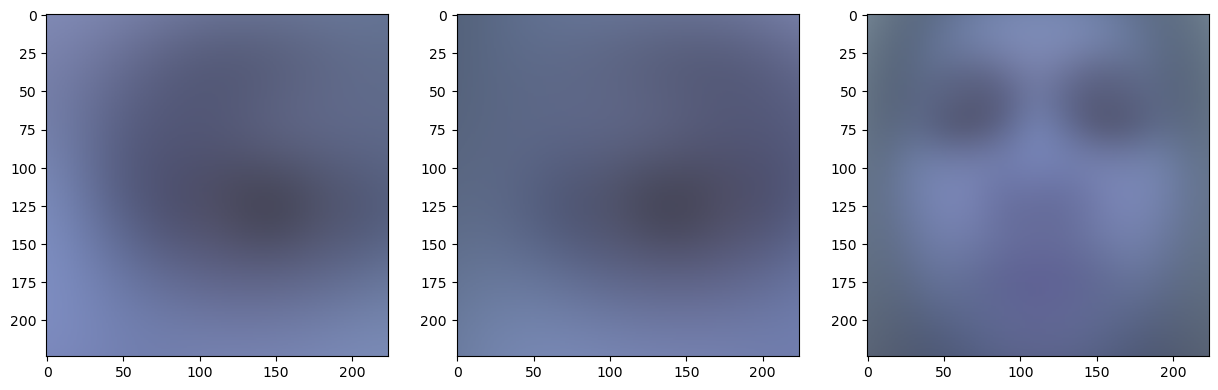

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, img in enumerate([left_eye_mean, right_eye_mean, face_mean]):
    axs[i].imshow(img.astype(np.uint8))
    
plt.show()

In [7]:
LEFT_EYE_IMG_PATH = 'imgs/left_eye.jpg'
RIGHT_EYE_IMG_PATH = 'imgs/right_eye.jpg'
FACE_IMG_PATH = 'imgs/face.jpg'

left_eye_img = Image.open(LEFT_EYE_IMG_PATH).convert('RGB')
right_eye_img = Image.open(RIGHT_EYE_IMG_PATH).convert('RGB')
face_img = Image.open(FACE_IMG_PATH).convert('RGB')

left_eye_img_np = np.array(left_eye_img)
right_eye_img_np = np.array(right_eye_img)
face_img_np = np.array(face_img)

In [8]:
class SubtractMean(object):
    def __init__(self, meanImg):
        self.meanImg = transforms.ToTensor()(meanImg / 255)

    def __call__(self, tensor):
        return tensor.sub(self.meanImg)

In [9]:
left_eye_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    SubtractMean(meanImg=left_eye_mean),
])
right_eye_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    SubtractMean(meanImg=right_eye_mean),
])
face_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    SubtractMean(meanImg=face_mean),
])

left_eye_img = left_eye_transform(left_eye_img)
right_eye_img = right_eye_transform(right_eye_img)
face_img = face_transform(face_img)

In [10]:
def makeGrid(params):
    gridLen = FACE_GRID_SIZE[0] * FACE_GRID_SIZE[1]
    grid = np.zeros([gridLen,], np.float32)
    
    indsY = np.array([i // FACE_GRID_SIZE[0] for i in range(gridLen)])
    indsX = np.array([i % FACE_GRID_SIZE[0] for i in range(gridLen)])
    condX = np.logical_and(indsX >= params[0], indsX < params[0] + params[2]) 
    condY = np.logical_and(indsY >= params[1], indsY < params[1] + params[3]) 
    cond = np.logical_and(condX, condY)

    grid[cond] = 1
    return grid

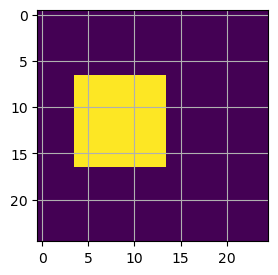

In [11]:
facegrid = makeGrid(sio.loadmat('reference_metadata.mat')['labelFaceGrid'][124, :])

plt.figure(figsize=(3, 3))
plt.imshow(facegrid.reshape(FACE_GRID_SIZE))
plt.grid()
plt.show()

facegrid = torch.FloatTensor(facegrid)

In [12]:
facegrid.dtype

torch.float32

In [13]:
imFace = face_img.to(torch.float32).reshape(1, 3, 224, 224)
imEyeL = left_eye_img.to(torch.float32).reshape(1, 3, 224, 224)
imEyeR = right_eye_img.to(torch.float32).reshape(1, 3, 224, 224)
faceGrid = facegrid.reshape(1, 25, 25)

with torch.no_grad():
    output = model(imFace, imEyeL, imEyeR, faceGrid)
    
output[0]

tensor([2.1283, 2.8105])